Epoch 1/150


C:\Users\Tyler\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 691711901696.0000 - mae: 431841.2500 - val_loss: 492104974336.0000 - val_mae: 407406.2188 - learning_rate: 0.0010
Epoch 2/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 375205986304.0000 - mae: 318856.5312 - val_loss: 240552034304.0000 - val_mae: 201455.2969 - learning_rate: 0.0010
Epoch 3/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 530540462080.0000 - mae: 203424.9844 - val_loss: 219188035584.0000 - val_mae: 184965.1875 - learning_rate: 0.0010
Epoch 4/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 339480379392.0000 - mae: 179999.5156 - val_loss: 205663567872.0000 - val_mae: 178104.5312 - learning_rate: 0.0010
Epoch 5/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 332492210176.0000 - mae: 174321.0000 - val_loss: 196602642432.0000 - val_mae: 174251.5000 - learning_rate: 0.0010
Epoch 6/150
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 250992820224.0000 - mae: 168147.9219 - val_loss: 190535385088.0000 - val_mae

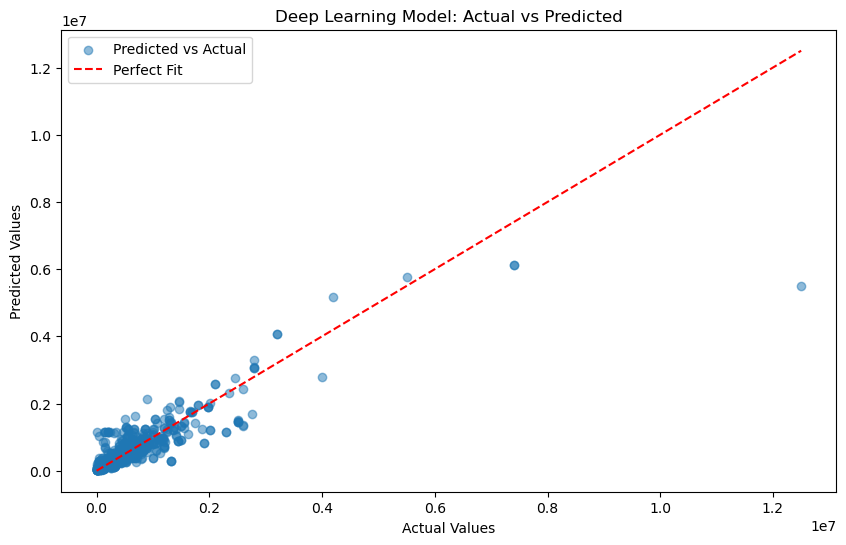

In [18]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


def preprocess_data(file_path, target_column):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Ensure target column is preserved before transformations
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataset.")
    
    y = df[target_column]
    df = df.drop(columns=[target_column])  # Exclude target column from preprocessing
    
    # Convert date columns to datetime format if they exist
    date_columns = ['list_date', 'sold_date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df[f'{col}_year'] = df[col].dt.year
            df[f'{col}_month'] = df[col].dt.month
            df = df.drop(columns=[col])
    
    # Identify categorical columns (excluding date columns)
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Fill missing values in categorical columns with a placeholder
    for col in categorical_columns:
        df[col] = df[col].astype(str).fillna('Unknown')
    
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
    
    # Fill missing numerical values with median
    for col in numerical_columns:
        df[col] = df[col].fillna(df[col].median())
    
    # Define the transformation pipeline
    transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
        ('scaler', StandardScaler(), numerical_columns)
    ])
    
    pipeline = Pipeline([
        ('transform', transformer)
    ])
    
    # Apply transformation
    df_encoded = pipeline.fit_transform(df)
    
    # Ensure transformed data is dense
    if hasattr(df_encoded, 'toarray'):
        df_encoded = df_encoded.toarray()
    
    return df_encoded, y.values


# Load data
file_path = os.getcwd() + "\\..\\csvFiles\\cleaned_data.csv"
target_column = "sold_price"
X, y = preprocess_data(file_path, target_column)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Simplified Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dense(1)  # Output layer for regression
])

# Compile Model with adjusted learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Define Callbacks with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, min_lr=1e-6)

# Train Model with fewer epochs
history = model.fit(
    X_train, y_train, 
    epochs=150, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping, lr_scheduler], 
    verbose=1
)

# Make Predictions
predictions = model.predict(X_test).flatten()

# Evaluate Model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Deep Learning Model: Actual vs Predicted")
plt.legend()
plt.show()
